# General API quickstart
https://docs.pymc.io/notebooks/api_quickstart.html

In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

/home/jmsung/miniconda/envs/pymc/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


# 1. Model creation
Models in PyMC3 are centered around the Model class. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a with context:

In [2]:
with pm.Model() as model:
    # Model definition
    pass

We discuss RVs further below but let’s create a simple model to explore the Model class.

In [3]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

In [4]:
model.basic_RVs

[mu, obs]

In [5]:
model.free_RVs

[mu]

In [6]:
model.observed_RVs

[obs]

In [7]:
model.logp({'mu': 0})

array(-141.7572668)

Warning It’s worth highlighting one of the counter-intuitive design choices with logp. The API makes the logp look like an attribute, when it actually puts together a function based on the current state of the model.

The current design is super maintainable, does terrible if the state stays constant, and great if the state keeps changing, for reasons of design we assume that Model isn’t static, in fact it’s best in our experience and avoids bad results.

If you need to use logp in an inner loop and it needs to be static, simply use something like logp = model.logp below. You can see the caching effect with the speed up below.


In [8]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

36.7 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
485 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# 2. Probability Distributions
Every probabilistic program consists of observed and unobserved Random Variables (RVs). Observed RVs are defined via likelihood distributions, while unobserved RVs are defined via prior distributions. In PyMC3, probability distributions are available from the main module space:

In [9]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In the PyMC3 module, the structure for probability distributions looks like this:

pymc3.distributions - continuous - discrete - timeseries - mixture

In [10]:
dir(pm.distributions.mixture)

['Discrete',
 'Distribution',
 'Iterable',
 'Mixture',
 'Normal',
 'NormalMixture',
 '_DrawValuesContext',
 '_DrawValuesContextBlocker',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_conversion_map',
 'all_discrete',
 'bound',
 'broadcast_distribution_samples',
 'draw_values',
 'generate_samples',
 'get_tau_sigma',
 'get_variable_name',
 'logsumexp',
 'np',
 'random_choice',
 'theano',
 'to_tuple',
 'tt']

## Unobserved Random Variables¶
Every unobserved RV has the following calling signature: name (str), parameter keyword arguments. Thus, a normal prior can be defined in a model context like this:

In [11]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1)

As with the model, we can evaluate its logp:

In [12]:
x.logp({'x': 0})

array(-0.91893853)

## Observed Random Variables
Observed RVs are defined just like unobserved RVs but require data to be passed into the observed keyword argument:



In [13]:
with pm.Model():
    obs = pm.Normal('x', mu=0, sigma=1, observed=np.random.randn(100))

observed supports lists, numpy.ndarray, theano and pandas data structures.

## Deterministic transforms¶
PyMC3 allows you to freely do algebra with RVs in all kinds of ways:



In [14]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1)
    y = pm.Gamma('y', alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

While these transformations work seamlessly, their results are not stored automatically. Thus, if you want to keep track of a transformed variable, you have to use pm.Deterministic:

In [15]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1)
    plus_2 = pm.Deterministic('x plus 2', x + 2)

Note that plus_2 can be used in the identical way to above, we only tell PyMC3 to keep track of this RV for us.

## Automatic transforms of bounded RVs¶
In order to sample models more efficiently, PyMC3 automatically transforms bounded RVs to be unbounded.

In [16]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1)

When we look at the RVs of the model, we would expect to find x there, however:

In [17]:
model.free_RVs

[x_interval__]

x_interval__ represents x transformed to accept parameter values between -inf and +inf. In the case of an upper and a lower bound, a LogOdds transform is applied. Sampling in this transformed space makes it easier for the sampler. PyMC3 also keeps track of the non-transformed, bounded parameters. These are common determinstics (see above):

In [18]:
model.deterministics

[x]

When displaying results, PyMC3 will usually hide transformed parameters. You can pass the include_transformed=True parameter to many functions to see the transformed parameters that are used for sampling.

You can also turn transforms off:



In [19]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1, transform=None)

print(model.free_RVs)

[x]


Or specify different transformation other than the default:

In [20]:
import pymc3.distributions.transforms as tr

with pm.Model() as model:
    # use the default log transformation
    x1 = pm.Gamma('x1', alpha=1, beta=1)
    # sepcified a different transformation
    x2 = pm.Gamma('x2', alpha=1, beta=1, transform=tr.log_exp_m1)

print('The default transformation of x1 is: ' + x1.transformation.name)
print('The user specified transformation of x2 is: ' + x2.transformation.name)

The default transformation of x1 is: log
The user specified transformation of x2 is: log_exp_m1


## Transformed distributions and changes of variables¶
PyMC3 does not provide explicit functionality to transform one distribution to another. Instead, a dedicated distribution is usually created in consideration of optimising performance. However, users can still create transformed distribution by passing the inverse transformation to transform kwarg. Take the classical textbook example of LogNormal: log(y)∼Normal(μ,σ)

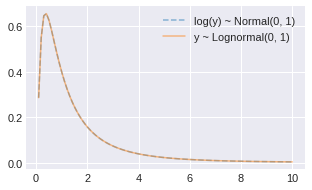

In [21]:
class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)


with pm.Model() as model:
    x1 = pm.Normal('x1', 0., 1., transform=Exp())
    x2 = pm.Lognormal('x2', 0., 1.)

lognorm1 = model.named_vars['x1_exp__']
lognorm2 = model.named_vars['x2']

_, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(0., 10., 100)
ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    '--',
    alpha=.5,
    label='log(y) ~ Normal(0, 1)')
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha=.5,
    label='y ~ Lognormal(0, 1)')
plt.legend();

Notice from above that the named variable x1_exp__ in the model is Lognormal distributed.
Using similar approach, we can create ordered RVs following some distribution. For example, we can combine the ordered transformation and logodds transformation using Chain to create a 2D RV that satisfy x1,x2∼Uniform(0,1) and x1<x2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


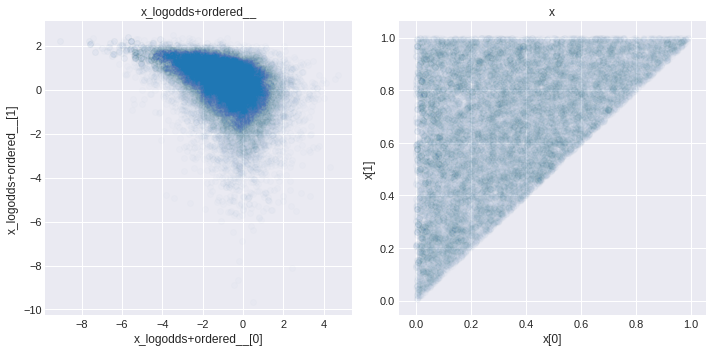

In [22]:
Order = tr.Ordered()
Logodd = tr.LogOdds()
chain_tran = tr.Chain([Logodd, Order])

with pm.Model() as m0:
    x = pm.Uniform(
        'x', 0., 1., shape=2,
        transform=chain_tran,
        testval=[0.1, 0.9])
    trace = pm.sample(5000, tune=1000, progressbar=False)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(trace.varnames):
    ax[ivar].scatter(trace[varname][:, 0], trace[varname][:, 1], alpha=.01)
    ax[ivar].set_xlabel(varname + '[0]')
    ax[ivar].set_ylabel(varname + '[1]')
    ax[ivar].set_title(varname)
plt.tight_layout()

## Lists of RVs / higher-dimensional RVs¶
Above we have seen how to create scalar RVs. In many models, you want multiple RVs. There is a tendency (mainly inherited from PyMC 2.x) to create list of RVs, like this:

In [23]:
with pm.Model():
    x = [pm.Normal('x_{}'.format(i), mu=0, sigma=1) for i in range(10)] # bad

However, even though this works it is quite slow and not recommended. Instead, use the shape kwarg:

In [24]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sigma=1, shape=10) # good

x is now a random vector of length 10. We can index into it or do linear algebra operations on it:



In [25]:
with model:
    y = x[0] * x[1] # full indexing is supported
    x.dot(x.T) # Linear algebra is supported

## Initialization with test_values¶
While PyMC3 tries to automatically initialize models it is sometimes helpful to define initial values for RVs. This can be done via the testval kwarg:

In [26]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1, shape=5)

x.tag.test_value

array([0., 0., 0., 0., 0.])

In [27]:
with pm.Model():
    x = pm.Normal('x', mu=0, sigma=1, shape=5, testval=np.random.randn(5))

x.tag.test_value

array([-1.33373637,  0.26626642,  0.02707856,  0.55685442,  0.86616304])

This technique is quite useful to identify problems with model specification or initialization.

# 3. Inference¶
Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: sampling and variational inference.

## 3.1 Sampling¶
The main entry point to MCMC sampling algorithms is via the pm.sample() function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don’t pass anything.

In [28]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    trace = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1012.09draws/s]


As you can see, on a continuous model, PyMC3 assigns the NUTS sampler, which is very efficient even for complex models. PyMC3 also runs variational inference (i.e. ADVI) to find good starting parameters for the sampler. Here we draw 1000 samples from the posterior and allow the sampler to adjust its parameters in an additional 500 iterations. These 500 samples are discarded by default:

In [29]:
len(trace)

1000

You can also run multiple chains in parallel using the cores kwarg:

In [30]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    trace = pm.sample(cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 939.38draws/s]
The acceptance probability does not match the target. It is 0.8867393205022179, but should be close to 0.8. Try to increase the number of tuning steps.


Note, that we are now drawing 2000 samples, 500 samples for 4 chains each. The 500 tuning samples are discarded by default.

In [31]:
trace['mu'].shape

(2000,)

In [32]:
trace.nchains

4

In [33]:
trace.get_values('mu', chains=1).shape # get values of a single chain

(500,)

PyMC3, offers a variety of other samplers, found in pm.step_methods.

In [34]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'SMC',
 'Slice']

Commonly used step-methods besides NUTS are Metropolis and Slice. For almost all continuous models, ``NUTS`` should be preferred. There are hard-to-sample models for which NUTS will be very slow causing many users to use Metropolis instead. This practice, however, is rarely successful. NUTS is fast on simple models but can be slow if the model is very complex or it is badly initialized. In the case of a complex model that is hard for NUTS, Metropolis, while faster, will have a very low effective sample size or not converge properly at all. A better approach is to instead try to improve initialization of NUTS, or reparameterize the model.

For completeness, other sampling methods can be passed to sample:

In [35]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:02<00:00, 2178.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


You can also assign variables to different step methods.

In [36]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    trace = pm.sample(10000, step=[step1, step2], cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████████████████████████| 42000/42000 [05:19<00:00, 131.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


## 3.2 Analyze sampling results¶
The most common used plot to analyze sampling results is the so-called trace-plot:

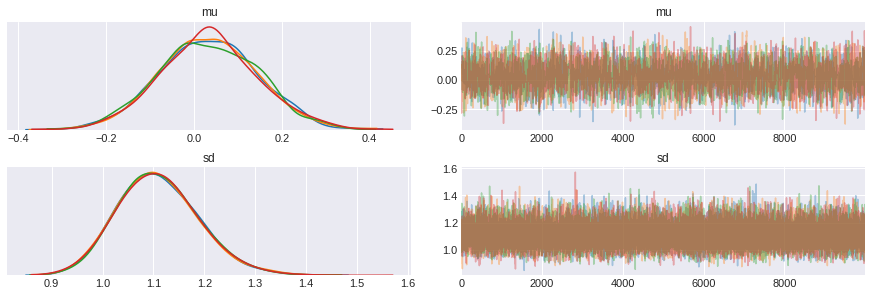

In [37]:
pm.traceplot(trace);

Another common metric to look at is R-hat, also known as the Gelman-Rubin statistic:



In [38]:
pm.gelman_rubin(trace)

{'mu': 1.0000168896982073, 'sd': 1.0000075275363112}

These are also part of the forestplot:

/home/jmsung/miniconda/envs/pymc/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/jmsung/miniconda/envs/pymc/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False
/home/jmsung/miniconda/envs/pymc/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/jmsung/miniconda/envs/pymc/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

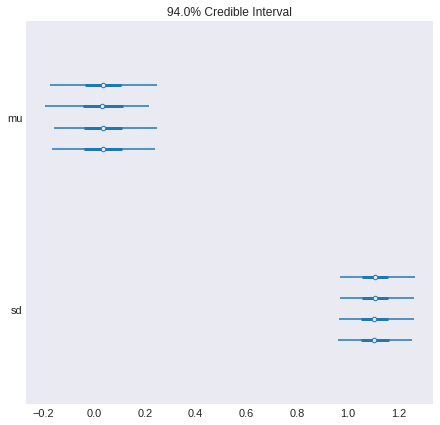

In [39]:
pm.forestplot(trace);

Finally, for a plot of the posterior that is inspired by the book Doing Bayesian Data Analysis, you can use the:

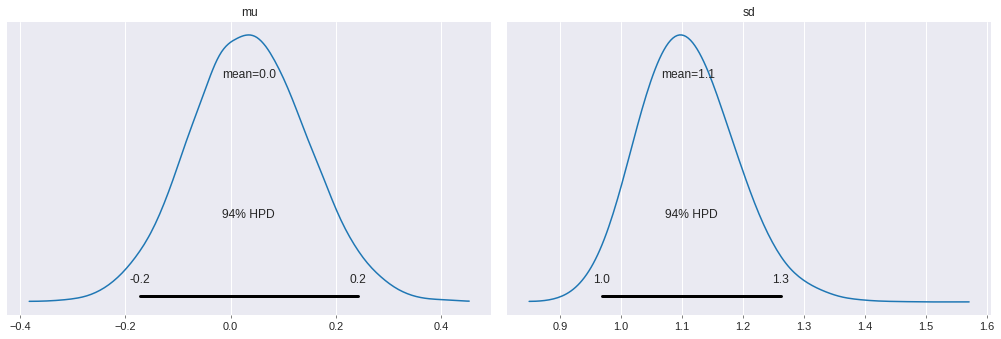

In [40]:
pm.plot_posterior(trace);

For high-dimensional models it becomes cumbersome to look at all parameter’s traces. When using NUTS we can look at the energy plot to assess problems of convergence:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:16<00:00, 248.70draws/s]


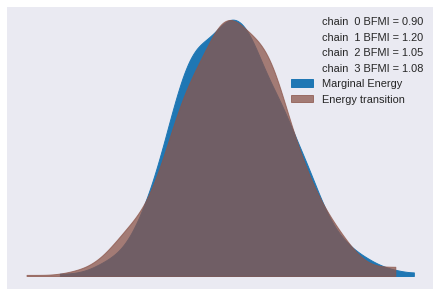

In [41]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sigma=1, shape=100)
    trace = pm.sample(cores=4)

pm.energyplot(trace);

For more information on sampler stats and the energy plot, see here. For more information on identifying sampling problems and what to do about them, see here.

## 3.3 Variational inference¶
PyMC3 supports various Variational Inference techniques. While these methods are much faster, they are often also less accurate and can lead to biased inference. The main entry point is pymc3.fit().

In [42]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=np.random.randn(100))

    approx = pm.fit()

Average Loss = 130.49: 100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [01:03<00:00, 158.33it/s]
Finished [100%]: Average Loss = 130.47


The returned Approximation object has various capabilities, like drawing samples from the approximated posterior, which we can analyse like a regular sampling run:



In [43]:
approx.sample(500)

<MultiTrace: 1 chains, 500 iterations, 3 variables>

The variational submodule offers a lot of flexibility in which VI to use and follows an object oriented design. For example, full-rank ADVI estimates a full covariance matrix:

In [44]:
mu = pm.floatX([0., 0.])
cov = pm.floatX([[1, .5], [.5, 1.]])
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.fit(method='fullrank_advi')

  0%|                                                                                                              | 0/10000 [00:00<?, ?it/s]/home/jmsung/miniconda/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jmsung/miniconda/envs/pymc/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/jmsung/miniconda/envs/pymc/lib/python3.7/site-packages/theano/t

An equivalent expression using the object-oriented interface is:

In [45]:
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.FullRankADVI().fit()

Average Loss = 0.01127: 100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 461.93it/s]
Finished [100%]: Average Loss = 0.011343


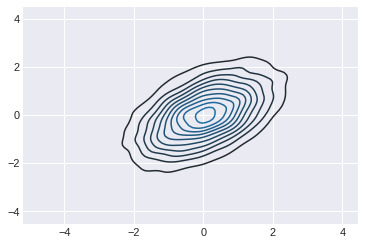

In [46]:
plt.figure()
trace = approx.sample(10000)
sns.kdeplot(trace['x'][:, 0], trace['x'][:, 1]);

Stein Variational Gradient Descent (SVGD) uses particles to estimate the posterior:

In [47]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])
with pm.Model() as model:
    pm.NormalMixture('x', w=w, mu=mu, sigma=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [4:28:58<00:00,  1.18s/it]


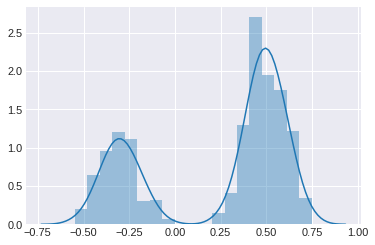

In [48]:
plt.figure()
trace = approx.sample(10000)
sns.distplot(trace['x']);

For more information on variational inference, see these examples.

# 4. Posterior Predictive Sampling¶
The sample_posterior_predictive() function performs prediction on hold-out data and posterior predictive checks.

In [49]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=data)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:22<00:00, 178.78draws/s]


In [50]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1717.17it/s]


sample_posterior_predictive() returns a dict with a key for every observed node:

In [51]:
post_pred['obs'].shape

(500, 100)

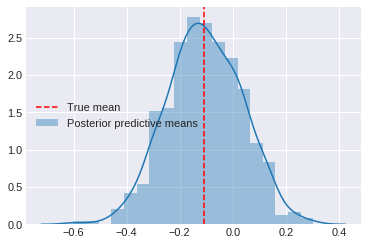

In [52]:
fig, ax = plt.subplots()
sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(data.mean(), ls='--', color='r', label='True mean')
ax.legend();

## 4.1 Predicting on hold-out data¶
In many cases you want to predict on unseen / hold-out data. This is especially relevant in Probabilistic Machine Learning and Bayesian Deep Learning. While we plan to improve the API in this regard, this can currently be achieved with a theano.shared variable. These are theano tensors whose values can be changed later. Otherwise they can be passed into PyMC3 just like any other numpy array or tensor.

This distinction is significant since internally all models in PyMC3 are giant symbolic expressions. When you pass data directly into a model, you are giving Theano permission to treat this data as a constant and optimize it away as it sees fit. If you need to change this data later you might not have a way to point at it in the symbolic expression. Using theano.shared offers a way to point to a place in that symbolic expression, and change what is there.



In [53]:
import theano

x = np.random.randn(100)
y = x > 0

x_shared = theano.shared(x)
y_shared = theano.shared(y)

with pm.Model() as model:
    coeff = pm.Normal('x', mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli('obs', p=logistic, observed=y_shared)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:19<00:00, 205.81draws/s]
The acceptance probability does not match the target. It is 0.897189229710802, but should be close to 0.8. Try to increase the number of tuning steps.


Now assume we want to predict on unseen data. For this we have to change the values of x_shared and y_shared. Theoretically we don’t need to set y_shared as we want to predict it but it has to match the shape of x_shared.

In [54]:
x_shared.set_value([-1, 0, 1.])
y_shared.set_value([0, 0, 0]) # dummy values

with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 201.30it/s]


In [55]:
post_pred['obs'].mean(axis=0)

array([0.018, 0.488, 0.982])